Reads file `query.csv`

for each image, generate refinements following naming like:
* `000001_refinement_A`
* `000002_refinement_B`
* `000002_refinement_C`

Save file `query_with_description.csv`

In [1]:
import pandas as pd
import os
import logging
from PIL import Image
from typing import List
import matplotlib.pyplot as plt
import openai
from openai.error import RateLimitError
import base64
import io
import dotenv
import time

dataset = 'urban-reid-challenge-reduced'

################ Probably nothing has to be modified from now on ################
logging.root.setLevel(logging.INFO)
dotenv.load_dotenv()

True

In [2]:
class VisualQnA():
    def predict(self, image: Image.Image, question: str) -> str:
        raise NotImplementedError()

class VisualQnAOpenAI(VisualQnA):
    def __init__(self, api_key, api_base, deployment_name, api_type="azure", api_version="2025-01-01-preview"):
        openai.api_key = api_key
        openai.api_base = api_base
        openai.api_type = api_type
        openai.api_version = api_version
        self.deployment_name = deployment_name

    def predict(self, image: Image.Image, question: str) -> str:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        image_b64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

        max_retries = 10
        backoff = 5  # initial backoff in seconds

        for attempt in range(max_retries):
            try:
                response = openai.ChatCompletion.create(
                    deployment_id=self.deployment_name,
                    messages=[
                        {"role": "system", "content": "You are a visual analyzer that provides short and descriptive answers."},
                        {"role": "user", "content": [
                            {"type": "text", "text": question},
                            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
                        ]}
                    ],
                    temperature=0.2
                )
                return response["choices"][0]["message"]["content"]
            except RateLimitError as e:
                if attempt < max_retries - 1:
                    logging.warning('Rate limited, trying again...')
                    time.sleep(backoff)
                    backoff *= 2  # exponential backoff
                else:
                    raise e

class VisualQnALlava(VisualQnA):
    # See https://huggingface.co/llava-hf/llava-1.5-7b-hf/discussions/52
    pass

In [3]:
# Classifying and describing each image
# TODO: the total prompt can't have more than 77 clip tokens
prompt = '''You are looking at an image of an urban object, that can be: a crosswalk, a container (big, for house trash of similar), or bin (small, for pedestrian rubbish).
First, write one single word with which of these 3 objects it is, full stop.
Then, describe in AT MOST 3 sentences the object, for re-identification purposes. Focus on physical characteristics that make it unique, such as: stickers, graffiti, wear markings, peeling, scratches, dents, nearby signage, etc.
Be very specific about _where_ is the characteristics (example: on the top-left corner) and _how_ (example: a 20cm light white graffiti of a rose).
Avoid general descriptions—highlight features that would help distinguish this object from visually similar ones, or any form of blabla that does not help identifying the object, just start describing right away.
'''
model = VisualQnAOpenAI(
    api_key=os.getenv('OPENAI_API_KEY'),
    api_base=os.getenv('OPENAI_API_BASE'),
    deployment_name=os.getenv('OPENAI_DEPLOYMENT_NAME'),
)


df = pd.read_csv(f'assets/datasets/{dataset}/query.csv')
df = df[~df['imageName'].str.contains('_refinement_')]
df['class'] = ''
df['description'] = ''

logging.info(f'Enriching {df.shape[0]} images')
for index, row in df.iterrows():
    image_path = os.path.join(f'assets/datasets/{dataset}/image_query', row['imageName'])
    image = Image.open(image_path)
    answer = model.predict(image, prompt)
    df.loc[index, 'class'] = answer.split('. ')[0].strip().lower()
    df.loc[index, 'description'] = '. '.join(answer.split('. ')[1:]).strip()
    logging.info('.')
    #logging.info(f"Image: {row['imageName']}, Answer: {description}")
    #break
#image
logging.info('Done')
df.to_csv(f'assets/datasets/{dataset}/query_with_description.csv', index=False)
df

INFO:root:Enriching 3 images
INFO:root:.
INFO:root:.
INFO:root:.
INFO:root:Done


,cameraID,imageName,class,description
0,c004,000001.jpg,crosswalk,"The crosswalk features five white stripes, wit..."
1,c004,000002.jpg,crosswalk,The crosswalk features worn white stripes that...
2,c004,000003.jpg,crosswalk,The crosswalk features four distinct white str...


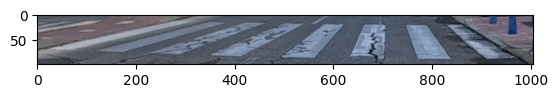

Class: crosswalk
Description: The crosswalk features five white stripes, with the second stripe from the left showing significant wear and a crack running through it. There are patches of faded paint on the edges of the stripes, particularly noticeable on the top-right corner of the third stripe. Additionally, the asphalt surrounding the crosswalk has visible cracks and uneven surfaces, enhancing its worn appearance.


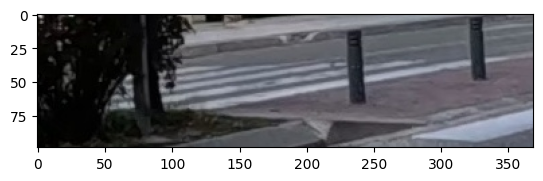

Class: crosswalk
Description: The crosswalk features worn white stripes that are slightly faded, particularly in the center where foot traffic is heaviest. There are small patches of peeling paint on the left edge of the crosswalk, revealing the underlying asphalt. Additionally, a nearby pole on the right side has a noticeable dent about halfway up, which could aid in locating the crosswalk in relation to it.


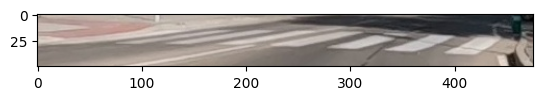

Class: crosswalk
Description: The crosswalk features four distinct white stripes that are slightly worn, with the leftmost stripe showing noticeable fading and a 10cm long scuff mark near the center. There is a small patch of asphalt repair visible on the right side of the crosswalk, which contrasts with the surrounding pavement. Additionally, a shadow from a nearby tree partially obscures the left side of the crosswalk, creating a distinct visual effect.


In [4]:
for index, row in df.iterrows():
    image_path = os.path.join(f'assets/datasets/{dataset}/image_query', row['imageName'])
    plt.imshow(plt.imread(image_path))
    plt.show()
    print('Class:', row['class'])
    print('Description:', row['description'])
    #break

In [6]:
# Refinements
refinement_templates = [  # tuples of <type, prompt>
    ('A', 'with a 2 people walking by and partially occluding it'),
    ('B', 'at sunset with a warm sun shinning on it'),
    ('C', 'on a rainy day, gray sky, low visibility'),
]
new_rows = []
for refinement_type, refinement_prompt in refinement_templates:
    for index, row in df.iterrows():
        new_rows.append([
            row['cameraID'],
            f"{row['imageName'].split('.')[0]}_refinement_{refinement_type}.{row['imageName'].split('.')[-1]}",
            row['class'],
            f"This exact same {row['class']} {refinement_prompt}. {row['description']}",
        ])
assert len(new_rows) == df.shape[0]*len(refinement_templates)
df2 = pd.concat([df, pd.DataFrame(new_rows, columns=['cameraID', 'imageName', 'class', 'description'])])
assert df2.shape[0] == df.shape[0]*(len(refinement_templates)+1)
assert df2.shape[1] == 4
df2.to_csv(f'assets/datasets/{dataset}/query_with_refinements.csv', index=False)
df2

,cameraID,imageName,class,description
0,c004,000001.jpg,crosswalk,"The crosswalk features five white stripes, wit..."
1,c004,000002.jpg,crosswalk,The crosswalk features worn white stripes that...
2,c004,000003.jpg,crosswalk,The crosswalk features four distinct white str...
0,c004,000001_refinement_A.jpg,crosswalk,This exact same crosswalk with a 2 people walk...
1,c004,000002_refinement_A.jpg,crosswalk,This exact same crosswalk with a 2 people walk...
2,c004,000003_refinement_A.jpg,crosswalk,This exact same crosswalk with a 2 people walk...
3,c004,000001_refinement_B.jpg,crosswalk,This exact same crosswalk at sunset with a war...
4,c004,000002_refinement_B.jpg,crosswalk,This exact same crosswalk at sunset with a war...
5,c004,000003_refinement_B.jpg,crosswalk,This exact same crosswalk at sunset with a war...
6,c004,000001_refinement_C.jpg,crosswalk,"This exact same crosswalk on a rainy day, gray..."
